In [1]:
import os
import math
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tensorboard.backend.event_processing import event_accumulator
pio.kaleido.scope.mathjax = None

In [2]:
LOG_DIR = "logs"
COLOR_MAPS = {
    "SupMAPPO": "#1fb45d",
    "GAILMAPPO": "#2c91db",
    "MAPPO": "#23cabc",
    "QMIX": "#FF7F0E",
    "IMAXPPO": "#D62728",
}
ALGOS = ["MAPPO", "QMIX", "SupMAPPO", "GAILMAPPO", "IMAXPPO"]

In [3]:
def read_tensorboard_events(folder):
    logs = []
    for file in os.listdir(folder):
        if "events" in file:
            event = event_accumulator.EventAccumulator(os.path.join(folder, file))
            event.Reload()
            tag = "game_eval/winrate"
            if tag not in event.scalars.Keys():
                tag = "game/winrate"
            logs += [(x.step, x.value) for x in event.Scalars(tag)]
    logs.sort(key=lambda x: x[0])
    return logs

In [4]:
def smooth(scalars, weight):
    last = 0
    smoothed = []
    for num_acc, next_val in enumerate(scalars):
        last = last * weight + (1 - weight) * next_val
        smoothed.append(last / (1 - math.pow(weight, num_acc+1)))
    return smoothed

In [5]:
def read_logs(ts_factor=0.9):
    inputs = []
    for algo in ALGOS:
        for env_name in os.listdir(f"{LOG_DIR}/{algo}"):
            inputs.append((algo, env_name))
    inputs.sort(key=lambda x: ALGOS.index(x[0]))
    data = {}
    for algo, env_name in inputs:
        steps, winrates = zip(*read_tensorboard_events(f"{LOG_DIR}/{algo}/{env_name}"))
        smooth_winrates = smooth(winrates, ts_factor)
        if env_name not in data:
            data[env_name] = {}
        data[env_name][algo] = (steps, winrates, smooth_winrates)
    return data
data = read_logs()

In [6]:
data_df = pd.DataFrame.from_dict(data)
data_df.to_pickle("saved_results/pickle_series.pkl")
mean_df = data_df.map(lambda x: x[-1][-1] if isinstance(x, tuple) else 0)
# std_df = data_df.map(lambda x: np.std(x[-2][-10:]) if isinstance(x, tuple) else 0)
def show_senarios(name):
    df_1 = mean_df.filter(regex=name).copy()
    df_1["average"] = df_1.mean(axis=1)
    # df_2 = std_df.filter(regex=name).copy()
    # df_2["average"] = df_2.mean(axis=1)
    df_1 = df_1.map(lambda x: f"{100*x:.2f}%")
    # df_2 = df_2.map(lambda x: f"{100*x:.2f}%")
    # display(df_1 + " +/- " + df_2)
    df_1 = df_1.sort_index()
    display(df_1)
show_senarios("protoss")
show_senarios("terran")
show_senarios("zerg")
show_senarios("miner")
show_senarios("academy")

,protoss_10_vs_10,protoss_10_vs_11,protoss_20_vs_20,protoss_20_vs_23,protoss_5_vs_5,average
GAILMAPPO,57.86%,21.86%,75.58%,12.57%,66.91%,46.96%
IMAXPPO,81.63%,48.92%,81.48%,22.83%,78.45%,62.66%
MAPPO,58.29%,17.15%,40.48%,4.94%,56.10%,35.39%
QMIX,69.56%,41.81%,71.91%,15.21%,69.37%,53.57%
SupMAPPO,71.26%,39.36%,72.57%,19.68%,71.24%,54.82%


,terran_10_vs_10,terran_10_vs_11,terran_20_vs_20,terran_20_vs_23,terran_5_vs_5,average
GAILMAPPO,63.17%,26.48%,36.65%,4.31%,56.24%,37.37%
IMAXPPO,80.33%,56.72%,69.42%,19.47%,74.87%,60.16%
MAPPO,57.27%,26.39%,52.57%,9.40%,49.86%,39.10%
QMIX,67.42%,41.47%,56.21%,8.31%,61.58%,47.00%
SupMAPPO,52.80%,26.34%,35.35%,12.58%,55.44%,36.50%


,zerg_10_vs_10,zerg_10_vs_11,zerg_20_vs_20,zerg_20_vs_23,zerg_5_vs_5,average
GAILMAPPO,50.65%,34.17%,28.10%,8.89%,45.00%,33.36%
IMAXPPO,56.81%,38.51%,43.41%,22.77%,51.75%,42.65%
MAPPO,39.51%,27.35%,34.44%,17.08%,45.28%,32.73%
QMIX,38.00%,24.32%,30.78%,9.53%,37.27%,27.98%
SupMAPPO,55.97%,41.15%,44.03%,12.92%,51.69%,41.15%


,miner_easy_2_vs_2,miner_hard_2_vs_2,miner_medium_2_vs_2,average
GAILMAPPO,55.55%,30.36%,39.61%,41.84%
IMAXPPO,62.11%,51.31%,56.01%,56.48%
MAPPO,51.83%,36.02%,42.92%,43.59%
QMIX,55.65%,40.11%,46.73%,47.50%
SupMAPPO,46.75%,33.05%,40.68%,40.16%


,academy_3_vs_1_with_keeper,academy_counterattack_easy,academy_counterattack_hard,average
GAILMAPPO,96.85%,62.56%,15.18%,58.20%
IMAXPPO,99.58%,95.80%,99.27%,98.21%
MAPPO,88.03%,87.76%,77.38%,84.39%
QMIX,8.12%,15.98%,3.22%,9.11%
SupMAPPO,97.02%,88.49%,10.51%,65.34%


In [7]:
def create_baseline_fig(data, showlegend_dict, min_x=1e4, max_x=10e6, min_y=1e-3, max_y=0.95, dtick_x=5e6, dtick_y=0.4, line_width=1.5, dash="solid"):
    fig = go.Figure()
    for algo in ALGOS:
        if algo not in data:
            continue
        steps, winrates, _ = data[algo]
        fig.add_trace(go.Scatter(x=steps, y=winrates, mode='lines', showlegend=False, line_color=COLOR_MAPS[algo], opacity=0.1, line_width=1))
    for algo in ALGOS:
        if algo not in data:
            continue
        steps, _, smooth_winrates = data[algo]
        showlegend = showlegend_dict.get(algo, True)
        showlegend_dict[algo] = False
        
        if algo == "IMAXPPO":
            name = "IMAX-PPO (Algo.1)"
        elif algo == "SupMAPPO":
            name = "IMAX-PPO (Sup)"
        elif algo == "GAILMAPPO":
            name = "IMAX-PPO (GAIL)"
        else:
            name = algo
        dash = "solid" if len(smooth_winrates) > 20 else dash
        fig.add_trace(go.Scatter(x=steps, y=smooth_winrates, mode='lines', showlegend=showlegend, name=name, 
                                 line_color=COLOR_MAPS[algo], line_width=2 if "ours" in name else line_width,
                                 line_dash=dash
                                 ))
    fig.update_layout(template='simple_white', margin=dict(l=4, r=4, t=4, b=4, pad=4, autoexpand=True))
    fig.update_layout(height=120, width=160)
    if min_x is not None:
        fig.update_xaxes(range=[min_x, max_x], dtick=dtick_x, minor=dict(ticklen=2))
    if min_y is not None:
        fig.update_yaxes(range=[min_y, max_y], dtick=dtick_y, minor=dict(ticklen=3, nticks=2))
    fig.update_layout(showlegend=False)
    return fig

In [8]:
plotly_figs, showlegend_dict = {}, {}
for env_name in sorted(data.keys()):
    if any(x in env_name for x in ["protoss", "terran", "zerg"]):
        plotly_figs[env_name] = create_baseline_fig(data[env_name], showlegend_dict)

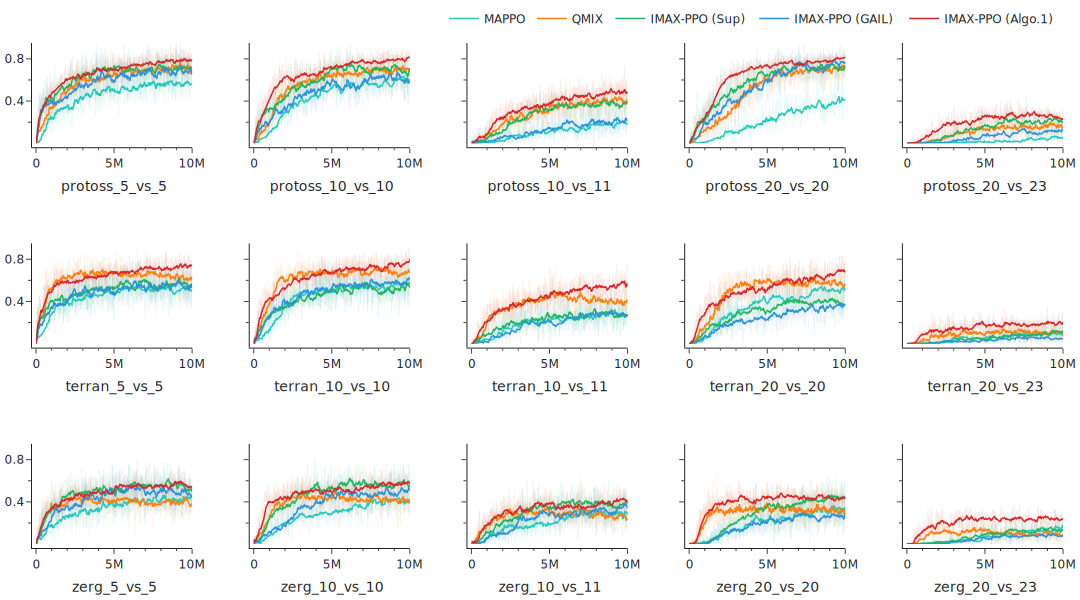

In [9]:
env_names = [env_name for env_name in plotly_figs if any(x in env_name for x in ["protoss", "terran", "zerg"])]
env_names.sort(key=lambda x: x.replace("5_vs_5", "05_vs_05"))
os.makedirs("graphs", exist_ok=True)
fig = make_subplots(rows=3, cols=5, horizontal_spacing=0.06, vertical_spacing=0.2)
for i, env_name in enumerate(env_names):
    plotly_fig = plotly_figs[env_name]
    plotly_fig.write_image(f"graphs/{env_name}.pdf")
    fig.add_traces(plotly_fig.data, rows=i//5+1, cols=i%5+1)
    fig['layout'][f'xaxis{i+1}'].update(title=env_name)
    fig['layout'][f'yaxis{i+1}'].update(showticklabels=i%5==0)
fig.update_layout(template='simple_white', margin=dict(l=4, r=4, t=4, b=4, pad=4, autoexpand=True))
fig.update_layout(height=200*3, width=180*6)
fig.update_xaxes(dtick=5e6, minor=dict(ticklen=2))
fig.update_yaxes(range=[1e-3, 0.95], dtick=0.4, minor=dict(ticklen=3, nticks=2))
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.update_layout(autosize=False)
fig.show("svg")
fig.update_layout(height=500, width=1000)
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.write_image(f"graphs/legend.pdf")

In [10]:
plotly_figs, showlegend_dict = {}, {}
for env_name in sorted(data.keys()):
    if "miner" in env_name:
        plotly_figs[env_name] = create_baseline_fig(data[env_name], showlegend_dict, max_x=2e6, max_y=0.69, min_y=0.16, dtick_x=1e6, dtick_y=0.2, line_width=2)

env_names: ['miner_easy_2_vs_2', 'miner_hard_2_vs_2', 'miner_medium_2_vs_2']


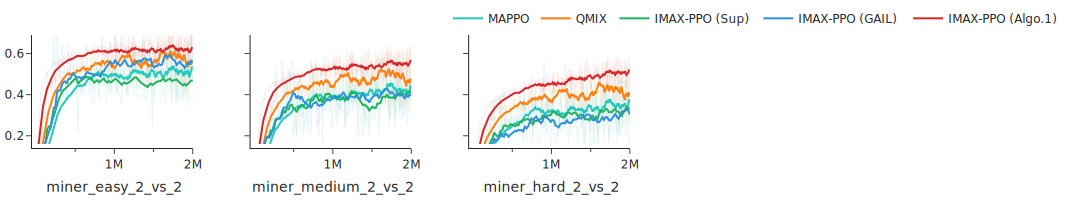

In [11]:
env_names = [env_name for env_name in plotly_figs if "miner" in env_name]
print("env_names:", env_names)
env_names.sort(key=lambda x: x.replace("hard", "xhard"))
os.makedirs("graphs", exist_ok=True)
fig = make_subplots(rows=1, cols=5, horizontal_spacing=0.06, vertical_spacing=0.2)
for i, env_name in enumerate(env_names):
    plotly_fig = plotly_figs[env_name]
    plotly_fig.write_image(f"graphs/{env_name}.pdf")
    fig.add_traces(plotly_fig.data, rows=i//5+1, cols=i%5+1)
    fig['layout'][f'xaxis{i+1}'].update(title=env_name)
    fig['layout'][f'yaxis{i+1}'].update(showticklabels=i%5==0)
fig.update_layout(template='simple_white', margin=dict(l=4, r=4, t=4, b=4, pad=4, autoexpand=True))
fig.update_layout(height=200, width=180*6)
fig.update_xaxes(dtick=1e6, minor=dict(ticklen=3,nticks=2))
fig.update_yaxes(range=[0.16, 0.69], dtick=0.2, minor=dict(ticklen=3, nticks=1))
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.update_layout(autosize=False)
fig.show("svg")

In [12]:
plotly_figs, showlegend_dict = {}, {}
for env_name in sorted(data.keys()):
    if "academy" in env_name:
        plotly_figs[env_name] = create_baseline_fig(data[env_name], showlegend_dict, max_x=5e5, dtick_x=2e5, min_y=None, dash="dash")

env_names: ['academy_3_vs_1_with_keeper', 'academy_counterattack_easy', 'academy_counterattack_hard']


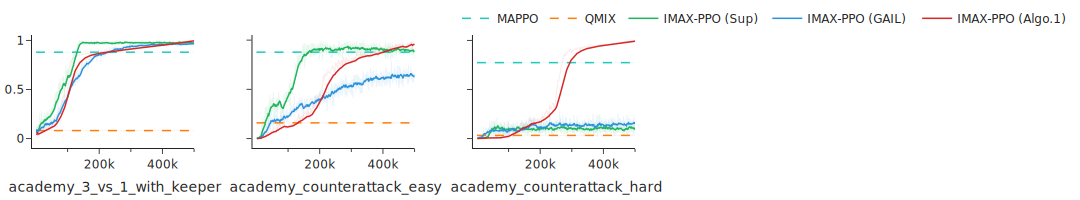

In [13]:
env_names = [env_name for env_name in plotly_figs if "academy" in env_name]
print("env_names:", env_names)
env_names.sort(key=lambda x: x.replace("hard", "xhard"))
os.makedirs("graphs", exist_ok=True)
fig = make_subplots(rows=1, cols=5, horizontal_spacing=0.06, vertical_spacing=0.2)
for i, env_name in enumerate(env_names):
    plotly_fig = plotly_figs[env_name]
    plotly_fig.write_image(f"graphs/{env_name}.pdf")
    fig.add_traces(plotly_fig.data, rows=i//5+1, cols=i%5+1)
    fig['layout'][f'xaxis{i+1}'].update(title=env_name)
    fig['layout'][f'yaxis{i+1}'].update(showticklabels=i%5==0)
fig.update_layout(template='simple_white', margin=dict(l=4, r=4, t=4, b=4, pad=4, autoexpand=True))
fig.update_layout(height=200, width=180*6)
fig.update_xaxes(range=[1e2, 5e5], dtick=2e5, minor=dict(ticklen=3,nticks=2))
# fig.update_yaxes(range=[0.16, 0.69], dtick=0.2, minor=dict(ticklen=3, nticks=1))
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.update_layout(autosize=False)
fig.show("svg")
fig.update_layout(height=500, width=1000)
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.write_image(f"graphs/legend_grf.pdf")